In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score


In [ ]:
# Load the data
customers_df = pd.read_csv('/content/Customers.csv')
transactions_df = pd.read_csv('/content/Transactions.csv')

In [ ]:
#Data Preprocessing
#Merge customer data with transaction data
data = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

#Feature Engineering - Transaction-based features
customer_features = data.groupby('CustomerID').agg(
    total_transactions=('TransactionID', 'count'),   # Total number of transactions
    unique_products=('ProductID', 'nunique'),         # Number of unique products bought
    recency=('TransactionDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days)  # Days since last transaction
).reset_index()

#Feature Engineering - Customer profile features
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
customers_df['tenure'] = (pd.to_datetime('today') - customers_df['SignupDate']).dt.days  # Number of days since signup


In [ ]:
#Merge transaction features with customer profile data
final_data = pd.merge(customer_features, customers_df[['CustomerID', 'Region', 'tenure']], on='CustomerID')

#Encode categorical features (Region)
label_encoder = LabelEncoder()
final_data['Region'] = label_encoder.fit_transform(final_data['Region'])

#Normalize numerical features
scaler = StandardScaler()
numerical_features = ['total_transactions', 'unique_products', 'recency', 'tenure']
final_data[numerical_features] = scaler.fit_transform(final_data[numerical_features])


In [ ]:
# Initialize inertia and DB Index lists
inertia = []
db_scores = []
silhouette_scores = []
range_values = range(2, 11)

for k in range_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(final_data[numerical_features])
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(final_data[numerical_features], cluster_labels))
    silhouette_scores.append(silhouette_score(final_data[numerical_features], cluster_labels))

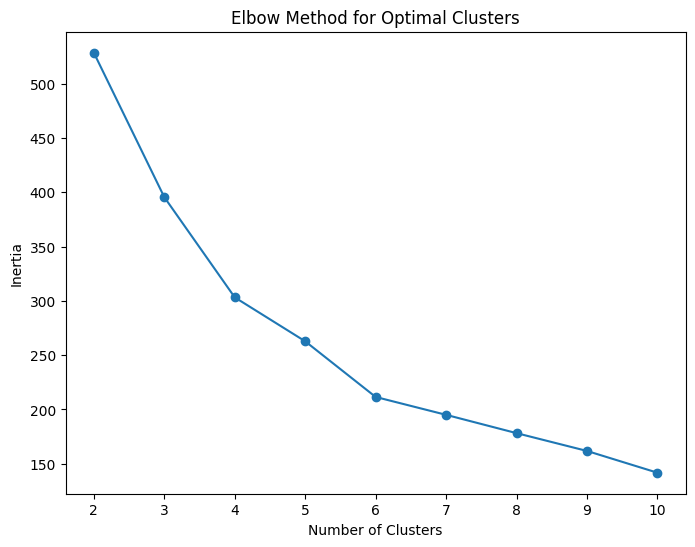

In [ ]:
# Plot Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range_values, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

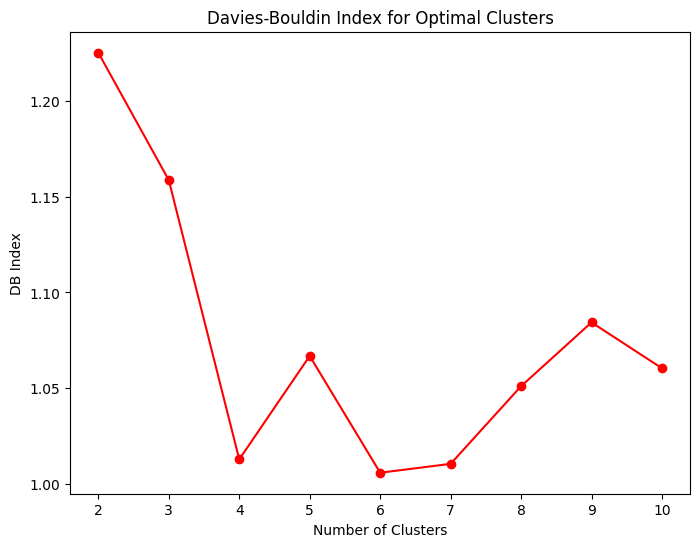

In [ ]:
# Plot Davies-Bouldin Index
plt.figure(figsize=(8, 6))
plt.plot(range_values, db_scores, marker='o', color='red')
plt.title('Davies-Bouldin Index for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

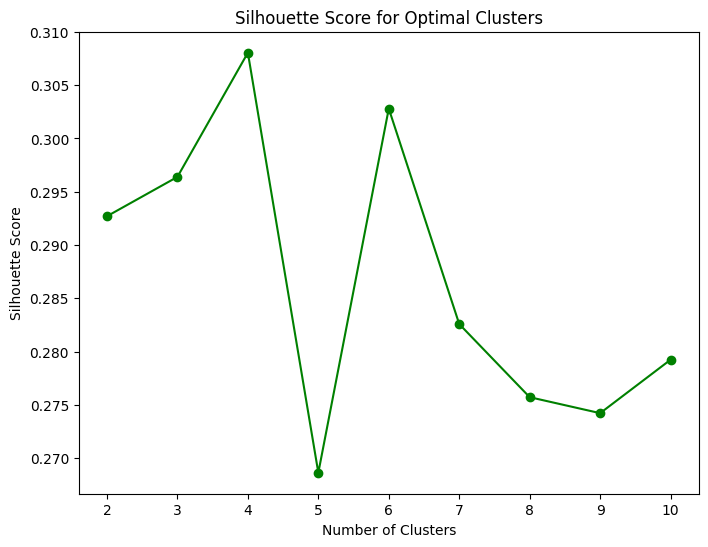

In [ ]:
# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(range_values, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
#Perform K-Means clustering with the optimal number of clusters (k=4 based on metrics)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
final_data['cluster'] = kmeans.fit_predict(final_data[numerical_features])

#Calculate Davies-Bouldin Index and Silhouette Score to evaluate clustering quality
db_index = davies_bouldin_score(final_data[numerical_features], final_data['cluster'])
silhouette_avg = silhouette_score(final_data[numerical_features], final_data['cluster'])
print(f'Davies-Bouldin Index: {db_index:.4f}')
print(f'Silhouette Score: {silhouette_avg:.4f}')

Davies-Bouldin Index: 1.0127
Silhouette Score: 0.3080


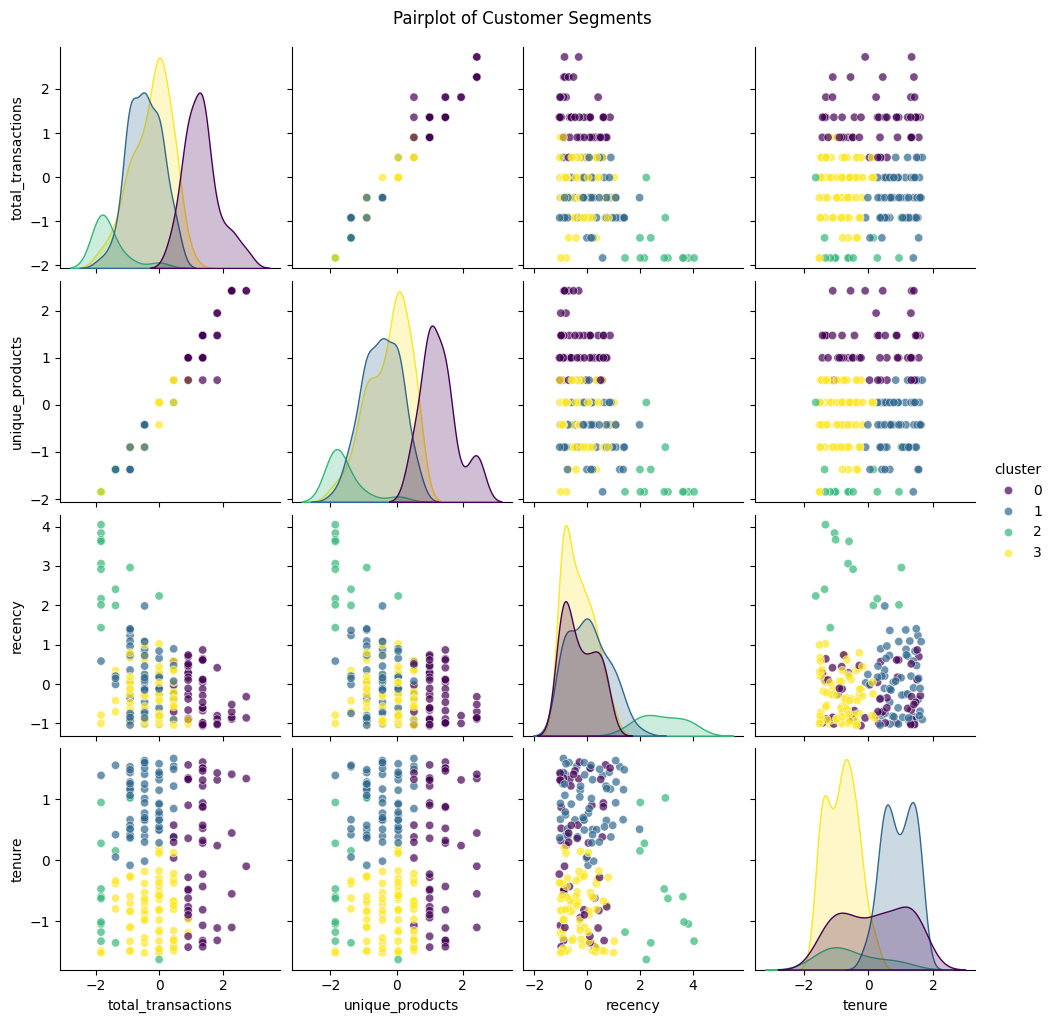

In [ ]:
# Visualize Clusters using Pairplot
# Visualize the relationships between numerical features using pairplot, with colors for clusters
sns.pairplot(final_data, hue='cluster', vars=numerical_features, palette='viridis', plot_kws={'alpha': 0.7})
plt.suptitle('Pairplot of Customer Segments', y=1.02)
plt.show()
print()

In [ ]:
#Analyze the clusters
# Calculate the mean of features within each cluster to understand cluster characteristics
cluster_summary = final_data.groupby('cluster')[['total_transactions', 'unique_products', 'recency', 'tenure']].mean()
print("\nCluster Summary (mean features per cluster):")
print(cluster_summary)


Cluster Summary (mean features per cluster):
         total_transactions  unique_products   recency    tenure
cluster                                                         
0                  1.311940         1.286818 -0.296484  0.169723
1                 -0.460139        -0.454801  0.038463  0.939217
2                 -1.554964        -1.555109  2.796759 -0.522766
3                 -0.248847        -0.235803 -0.323588 -0.823170
